MIE1622 - Assignment #2

Alexander Cheng

Student Number: 1001634298

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.sparse import csr_matrix
import cyipopt as ipopt
import copy

C:\Users\alex_\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:20: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [2]:
def roundfun(x_share):
    uplist = []
    x_round = np.round(x_share)
    j = 0
    for j in range(len(x_share)):
        if x_round[j] <= x_share[j]:
            uplist.append(0)
        else:
            uplist.append(1)
        j = j+1
    return x_round, uplist

In [3]:
# Example of rounded function

Z = [ 675.78975593 ,1018.34313283,   26.34372106 ,1468.29399009, 1041.61614148,
  659.93801356, 1097.86158098, 5425.37603531,   36.56702023, 1389.92028308,
  2560.43840833 , 426.9158793 ,  864.11348986 , 378.73721687, 1013.31610082,
  317.23253371 , 835.76164646 , 724.01749255, 1507.14437998,  904.34406961]
Z = np.array(Z)

a, b = roundfun(Z)
print(a)
print(b)

[ 676. 1018.   26. 1468. 1042.  660. 1098. 5425.   37. 1390. 2560.  427.
  864.  379. 1013.  317.  836.  724. 1507.  904.]
[1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0]


In [4]:
# Complete the following functions

# Strategy 1
def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
   x_optimal = x_init
   cash_optimal = cash_init
   weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
   return x_optimal, cash_optimal, weight_optimal

# Strategy 2
def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):

    x_ratio = 1 / cur_prices # Amount of money to put in each stock, weighted equally
    p_current = np.dot(x_init, cur_prices)
    x_share = p_current/N * x_ratio
    x_optimal, roundlist = roundfun(x_share) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):

        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal) # Number of units changed
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC

        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 # Buy 1 less stock of all stocks above 1
            # This would essentially round all share units down 1 so you would have enough money
            # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
    
    # Use extra cash since we undershot our number of stocks
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        # Cost adding 1 extra unit
        current_price = current_price + cur_prices[i]
        
        # Don't add the units that were rounded down or if not enough money
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        # Add only the units that were supposed to be rounded up
        else:
            extra_share.append(1) # Include stock

    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)

    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)

    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)

    return x_optimal, cash_optimal, weight_optimal

# Strategy 3
def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):

    # Initialize the CPLEX Object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define linear part of objective function and bounds on variables
    c  = [0.0] * N # Weights
    lb = [0.0] * N # No short selling boundary
    ub = [1.0] * N # Upper limit boundary
    
    # Define constraint matrix A
    A = []
    
    for k in range(N):
        A.append([[0],[1.0]]) # Upper limit boundary
    
    # Add objective function, bounds on variables and linear constraints to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E") # Sum of weights add up to 1
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute minimum variance with CPLEX
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # Optimize the problem
    cpx.solve()
    
    x_ratio = np.array(cpx.solution.get_values()) # Weight to put in each stock
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Use extra cash since we undershot our number of stocks
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        # Cost adding 1 extra unit
        current_price = current_price + cur_prices[i]
        
        # Don't add the units that were rounded down or if not enough money
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        # Add only the units that were supposed to be rounded up
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)

    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)  
    
    return x_optimal, cash_optimal, weight_optimal

# Strategy 4
def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):

    # Initialize the CPLEX Object
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    # Define linear part of objective function and bounds on variables
    c  = [0.0] * N
    lb = [0.0] * N
    ub = [cplex.infinity] * N
    
    # Define constraint matrix A
    A = []
    
    for k in range(N):
        A.append([[0],[mu[k] - 1/252 * r_rf]]) # Annual risk free rate given, convert to daily
    
    # Add objective function, bounds on variables and linear constraints to CPLEX model
    var_names = ["w_%s" % i for i in range(1,N+1)]
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb = lb, ub=ub, columns=A, names=var_names)
    
    # Add quadratic part of objective function to CPLEX model
    Qmat = [[list(range(N)), list(2*Q[k,:])] for k in range(N)]
    cpx.objective.set_quadratic(Qmat)

    cpx.parameters.threads.set(4)
    
    # Disable CPLEX output to screen
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    
    # Compute minimum variance with CPLEX
    alg = cpx.parameters.lpmethod.values
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    # Optimize the problem
    cpx.solve()
    
    if cpx.solution.get_status_string()=='infeasible': # Hold the previous weights
        x_optimal=x_init
        cash_optimal=cash_init
        weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
        return x_optimal, cash_optimal, weight_optimal
    
    else:
        # get x_optimal
        y = np.array(cpx.solution.get_values())
        x_ratio = y / np.sum(y)
        p_current = np.dot(x_init, cur_prices)
        v_current = p_current * x_ratio
        x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock

        first_run = True # First run to determine if there'e enough money in cash account
        positive_cash = False

        # Loop will repeat until enough money in cash account
        while(positive_cash == False):

            # Calculate V_sell
            x_sell = x_init - x_optimal
            x_sell[x_sell < 0] = 0
            V_sell = np.dot(cur_prices, x_sell)

            # Calculate V_buy
            x_buy = x_optimal - x_init
            x_buy[x_buy < 0] = 0
            V_buy = np.dot(cur_prices, x_buy)

            # Calculate transaction cost
            x_change = np.abs(x_init - x_optimal)
            TC = 0.005 * np.dot(cur_prices, x_change)

            # Calculate cash account
            cash_optimal = cash_init + V_sell - V_buy - TC

            # check if cash_optimal>0
            if cash_optimal < 0:
                # Buy 1 less share of all stocks in portfolio that were rounded up
                if(first_run):
                    x_optimal = x_optimal - roundlist 
                    first_run = False
                # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
                else:
                    x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
            # This would essentially round all share units down 1 so you would have enough money
            # Rounded up stocks will go down two units 
            else:
                positive_cash = True # Now cash is positive

        # Need to use extra cash
        cash_onhand = cash_optimal*0.995 # To account for transaction fee
        current_price = 0
        extra_share = []
        i = 0

        for i in range(N):
            current_price = current_price + cur_prices[i]
            if current_price > cash_onhand or roundlist[i] == 0:
                current_price = current_price - cur_prices[i]
                extra_share.append(0) # Don't include stock
            else:
                extra_share.append(1) # Include stock

        # Add the extra share of stock to x_optimal
        x_optimal = x_optimal + np.array(extra_share)

        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)

        # Recalculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
        weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)

        return x_optimal, cash_optimal, weight_optimal

In [5]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
                fval = fval + xij*xij
        fval = 2*fval
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        grad = np.zeros(n)
        y = x * np.dot(Q,x)
        # Insert your gradient computations here
        for i in range(n):
          for j in range(n):
            grad[i] = grad[i] + 2*2*(y[i] - y[j])*np.dot(Q,x)[i]
        # You can use finite dif*ferences to check the gradient
        return grad

    def constraints(self, x):
        # The callback for calculating the constraints
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        return np.array([[1.0] * n])

In [6]:
# Strategy 5
def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):

    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
    w0 = [1.0/n] * n # An array of weighted risks
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)

    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

    x_ratio = w_erc/np.sum(w_erc) # Amount of money to put in each stock, weighted equally
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there's enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Need to use extra cash
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        current_price = current_price + cur_prices[i]
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)
    
    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)

    return x_optimal, cash_optimal, weight_optimal

# Strategy 6
def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
    w0 = [1.0/n] * n # An array of weighted risks
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.Problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)
    
    # Set the IPOPT options
    nlp.add_option('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.add_option('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.add_option('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.add_option('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)

    # Compute variance and asset risk contributions for the ERC portfolio
    var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
    std_ERC = np.sqrt(var_ERC)
    RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC
    
    # 200% Long leverage positions
    if(period == 1):
        x_init = 2 * x_init
    
    x_ratio = w_erc/np.sum(w_erc) # Amount of money to put in each stock, weighted equally
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Need to use extra cash
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        current_price = current_price + cur_prices[i]
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)
    
    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
    
    return x_optimal, cash_optimal, weight_optimal

# Strategy 7
def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    
    # Use "1/n portfolio" w0 as initial portfolio
    w0 = [1.0/n] * n # An array of weighted risks
    ret_init=np.dot(mu,w0)  # 1/n portfolio return
    var_init=np.dot(w0,np.dot(Q,w0)) # 1/n portfolio var
    
    # Required portfolio robustness
    var_matr = np.diag(np.diag(Q))
    # Target portfolio return estimation error is return estimation error of 1/n portfolio
    rob_init = np.dot(w0, np.dot(var_matr, w0)) # return estimation error of initial portfolio
    rob_bnd  = rob_init # target return estimation error
    
    #Compute minimum variance portfolio
    w_minVar = strat_min_variance(x_init, cash_init, mu, Q, cur_prices)[2]
    ret_minVar = np.dot(mu, w_minVar)
    
    # Target portfolio return is return of minimum variance portfolio
    Portf_Retn = ret_minVar
    
    # Define and solve CPLEX robust mean-variance model directly without CVXPY
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    
    A = []
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
        
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn], senses="EG")
    
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A, names=var_names)
    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
    
    Qcon = cplex.SparseTriple(ind1=var_names, ind2=range(n), val=np.diag(var_matr)) # USed variances
    cpx.quadratic_constraints.add(rhs=rob_bnd, quad_expr=Qcon, name="Qc")
    
    cpx.parameters.threads.set(4)
    #print("Setting number of threads = ", 4)
    cpx.parameters.timelimit.set(60)
    #print("Setting timelimit = ", 60)
    cpx.parameters.barrier.qcpconvergetol.set(1e-12)
    #print("Setting Barrier algorithm convergence tolerance = ", 1e-12)
    cpx.set_results_stream(None)
    cpx.solve()
    
    w_rMV = cpx.solution.get_values()
    #card_rMV = np.count_nonzero(w_rMV)
    #ret_rMV  = np.dot(mu, w_rMV)
    #var_rMV = np.dot(w_rMV, np.dot(Q, w_rMV))
    #rob_rMV = np.dot(w_rMV, np.dot(var_matr, w_rMV))
    
    # Round near-zero portfolio weights, if necessary. This is done through rounding function already
    w_rMV = np.array(w_rMV)
    #w_rMV_nonrnd = copy.deepcopy(w_rMV)
    #w_rMV[w_rMV<1e-6] = 0
    #w_rMV = w_rMV / np.sum(w_rMV)
    #w_list = [w_rMV_nonrnd, w_rMV] 

    x_ratio = w_rMV/np.sum(w_rMV) # Amount of money to put in each stock, weighted equally
    p_current = np.dot(x_init, cur_prices)
    v_current = p_current * x_ratio
    x_optimal, roundlist = roundfun(v_current / cur_prices) # Rounding strategy of each stock
    
    first_run = True # First run to determine if there'e enough money in cash account
    positive_cash = False
    
    # Loop will repeat until enough money in cash account
    while(positive_cash == False):
        
        # Calculate V_sell
        x_sell = x_init - x_optimal
        x_sell[x_sell < 0] = 0
        V_sell = np.dot(cur_prices, x_sell)

        # Calculate V_buy
        x_buy = x_optimal - x_init
        x_buy[x_buy < 0] = 0
        V_buy = np.dot(cur_prices, x_buy)

        # Calculate transaction cost
        x_change = np.abs(x_init - x_optimal)
        TC = 0.005 * np.dot(cur_prices, x_change)
        
        # Calculate cash account
        cash_optimal = cash_init + V_sell - V_buy - TC
            
        # check if cash_optimal>0
        if cash_optimal < 0:
            # Buy 1 less share of all stocks in portfolio that were rounded up
            if(first_run):
                x_optimal = x_optimal - roundlist 
                first_run = False
            # Buy 1 less share of all stocks in portfolio (if there isn't enough money)
            else:
                x_optimal[x_optimal > 1] = x_optimal[x_optimal > 1]- 1 #Buy 1 less stock of all stocks above 1
        # This would essentially round all share units down 1 so you would have enough money
        # Rounded up stocks will go down two units 
        else:
            positive_cash = True # Now cash is positive
        
    # Need to use extra cash
    cash_onhand = cash_optimal*0.995 # To account for transaction fee
    current_price = 0
    extra_share = []
    i = 0
    
    for i in range(N):
        current_price = current_price + cur_prices[i]
        if current_price > cash_onhand or roundlist[i] == 0:
            current_price = current_price - cur_prices[i]
            extra_share.append(0) # Don't include stock
        else:
            extra_share.append(1) # Include stock
    
    # Add the extra share of stock to x_optimal
    x_optimal = x_optimal + np.array(extra_share)
    
    # Calculate V_sell
    x_sell = x_init - x_optimal
    x_sell[x_sell < 0] = 0
    V_sell = np.dot(cur_prices, x_sell)

    # Calculate V_buy
    x_buy = x_optimal - x_init
    x_buy[x_buy < 0] = 0
    V_buy = np.dot(cur_prices, x_buy)

    # Calculate transaction cost
    x_change = np.abs(x_init - x_optimal)
    TC = 0.005 * np.dot(cur_prices, x_change)
    
    # Recalculate cash account
    cash_optimal = cash_init + V_sell - V_buy - TC
    weight_optimal = x_optimal * cur_prices / np.dot(cur_prices, x_optimal)
    
    return x_optimal, cash_optimal, weight_optimal

# Test Strategy for 2020-2021 Data

In [7]:
# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2019 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2019)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2019
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2020-2021 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375


Initial portfolio value = $ 1000013.0



In [8]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]
n=N

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

port_value_period = np.zeros((N_strat, N_periods+1),  dtype=np.ndarray)
v_borrowed = init_value

global period 

for period in range(1, N_periods+1):
    
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2020 + math.floor(period/7)

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # verify strategy is feasible
      if cash[strategy].any() < 0:
          print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

      # Compute portfolio value
      if strategy == 5: # Subtract borrowed money with interest
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]  - v_borrowed*(1.0+r_rf/6.0)**period # assuming compound interest
      else:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2020, end date 02/28/2020
  Strategy "Buy and Hold", value begin = $ 1000013.00, value end = $ 893956.82
  Strategy "Equally Weighted Portfolio", value begin = $ 990881.79, value end = $ 892364.23
  Strategy "Mininum Variance Portfolio", value begin = $ 992756.22, value end = $ 915849.88
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990063.46, value end = $ 922016.34
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 991597.39, value end = $ 898259.85
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 979011.20, value end = $ 792347.88
  Strategy "Robust Optimization Portfolio", value begin = $ 992167.76, value end = $ 917120.45

Period 2: start date 03/02/2020, end date 04/30/2020
  Strategy "Buy and Hold", value begin = $ 945076.08, value end = $ 949228.39
  Strategy "Equally Weighted Portfolio", value begin = $ 930690.93, value end = $ 862192.32
  Strategy "Mininum Variance Portfolio", value begin = $ 9

  Strategy "Mininum Variance Portfolio", value begin = $ 1053826.83, value end = $ 1047867.41
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 2112459.87, value end = $ 2216770.75
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1462333.67, value end = $ 1515001.16
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1874911.73, value end = $ 1980093.88
  Strategy "Robust Optimization Portfolio", value begin = $ 1228963.76, value end = $ 1256306.78


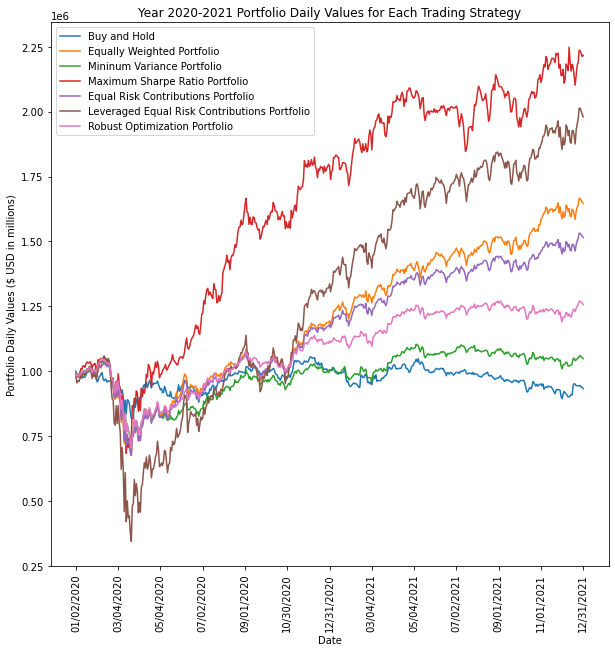

In [9]:
# Plot results
###################### Insert your code here ############################

# This chart illustrates the daily value of the portfolio for each 
# trading strategy over the years 2020 and 2021 using the daily prices. 

figure(figsize=(10, 10))

# Plotting the points
plt.plot(dates, portf_value[0], label = strategy_names[0])
plt.plot(dates, portf_value[1], label = strategy_names[1])
plt.plot(dates, portf_value[2], label = strategy_names[2])
plt.plot(dates, portf_value[3], label = strategy_names[3])
plt.plot(dates, portf_value[4], label = strategy_names[4])
plt.plot(dates, portf_value[5], label = strategy_names[5])
plt.plot(dates, portf_value[6], label = strategy_names[6])

# X axis date ticks
plt.xticks(list(dates[k] for k in list(np.linspace(0,252*2,13,dtype=int))),rotation=90)

# Labelling
plt.xlabel('Date')
plt.ylabel('Portfolio Daily Values ($ USD in millions)')
plt.title('Year 2020-2021 Portfolio Daily Values for Each Trading Strategy')
plt.legend()
plt.show()

In [10]:
df_port_vale_period = pd.DataFrame(port_value_period.T.tolist(),columns=strategy_names)
array_portf_value = np.array(portf_value)
array_portf_value = array_portf_value.reshape(7,505)
df_port_value_daily = pd.DataFrame(array_portf_value.T.tolist(),columns=strategy_names)
df_port_value_daily

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Equal Risk Contributions Portfolio,Leveraged Equal Risk Contributions Portfolio,Robust Optimization Portfolio
0,1.000013e+06,9.908818e+05,9.927562e+05,9.900635e+05,9.915974e+05,9.790112e+05,9.921678e+05
1,9.890027e+05,9.779840e+05,9.814980e+05,9.772296e+05,9.796000e+05,9.549963e+05,9.813105e+05
2,9.871785e+05,9.812937e+05,9.857906e+05,9.847558e+05,9.837350e+05,9.632617e+05,9.856731e+05
3,9.760963e+05,9.791665e+05,9.850986e+05,9.877462e+05,9.820192e+05,9.598341e+05,9.834140e+05
4,9.782857e+05,9.845903e+05,9.916647e+05,9.969739e+05,9.875124e+05,9.707980e+05,9.899032e+05
...,...,...,...,...,...,...,...
500,9.437578e+05,1.666775e+06,1.057085e+06,2.237145e+06,1.531823e+06,2.013773e+06,1.268369e+06
501,9.452071e+05,1.664731e+06,1.060498e+06,2.233786e+06,1.531381e+06,2.012905e+06,1.270185e+06
502,9.391084e+05,1.657950e+06,1.054698e+06,2.225061e+06,1.525551e+06,2.001229e+06,1.265488e+06
503,9.374499e+05,1.651175e+06,1.052290e+06,2.212722e+06,1.520128e+06,1.990381e+06,1.262053e+06


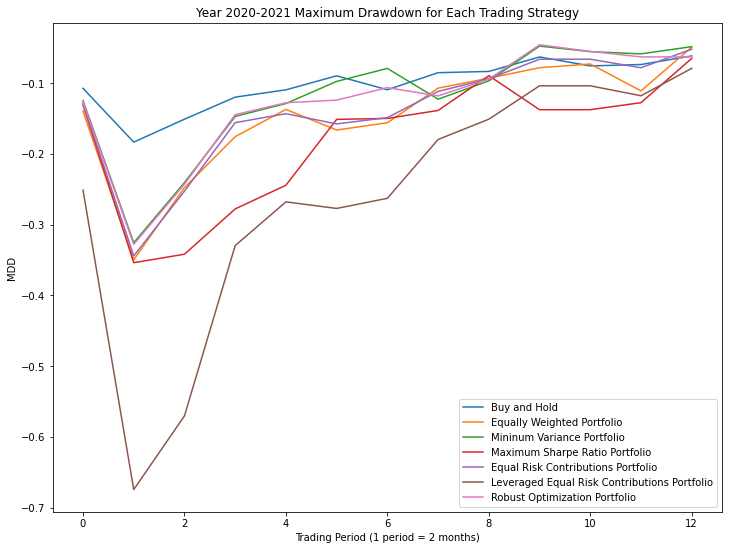

In [11]:
plt.figure(figsize=(12, 9))
plt.ylabel('MDD')
plt.xlabel('Trading Period (1 period = 2 months)')
plt.title('Year 2020-2021 Maximum Drawdown for Each Trading Strategy')
for i in range(7):
    
    Roll_Max = df_port_value_daily[strategy_names[i]].rolling(42).max()
    Roll_Min = df_port_value_daily[strategy_names[i]].rolling(42).min()
    Daily_Drawdown = (Roll_Min - Roll_Max) / Roll_Max
    Max_Drawdown = Daily_Drawdown.groupby(np.arange(len(Daily_Drawdown))//42).min()

    # Plot the results
    Max_Drawdown.plot(label=strategy_names[i])
    plt.legend()

In [12]:
weight_6 = weight[6].tolist()
weight_6_df = pd.DataFrame(weight_6, columns = df.columns[1:]) # Remove the date

Text(0.5, 1.0, 'Year 2020-2021 Dynamic Changes in Portfolio Allocations for Robust Optimization Strategy')

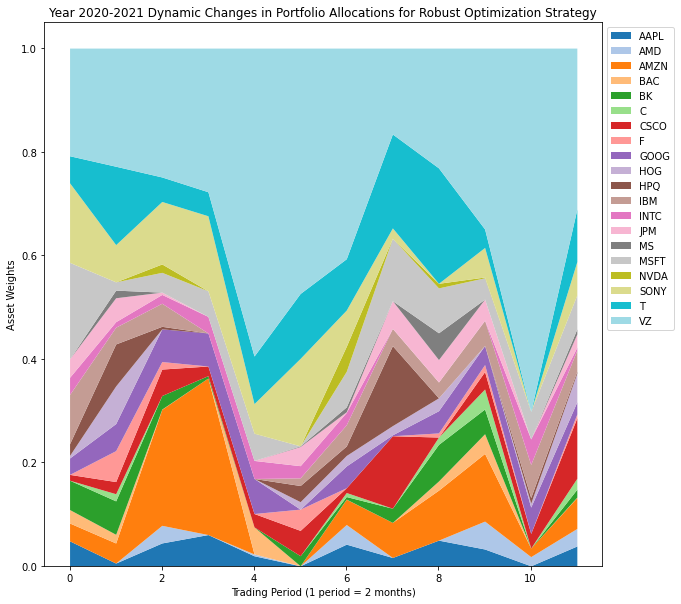

In [13]:
fig = weight_6_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2020-2021 Dynamic Changes in Portfolio Allocations for Robust Optimization Strategy')

Text(0.5, 1.0, 'Year 2020-2021 Dynamic Changes in Portfolio Allocations for Minimum Variance')

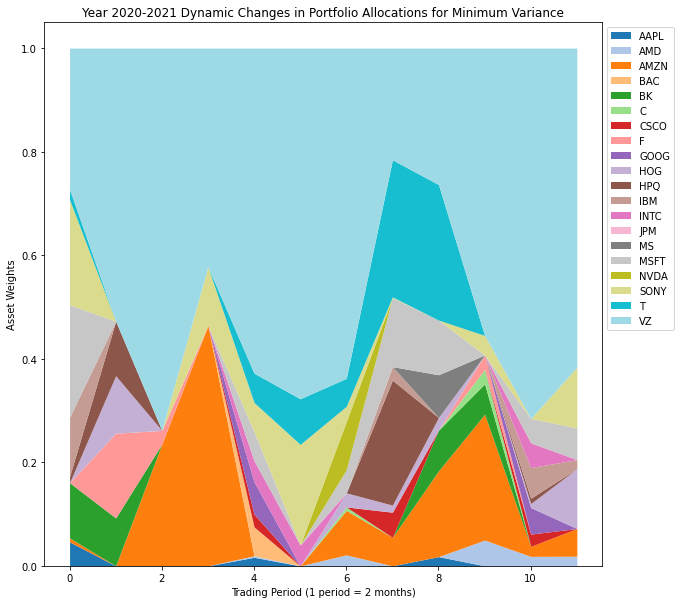

In [14]:
weight_2 = weight[2].tolist()
weight_2_df = pd.DataFrame(weight_2, columns = df.columns[1:]) # Remove the date

weight_2_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2020-2021 Dynamic Changes in Portfolio Allocations for Minimum Variance')

Text(0.5, 1.0, 'Year 2020-2021 Dynamic Changes in Portfolio Allocations for Maximum Sharpe Ratio')

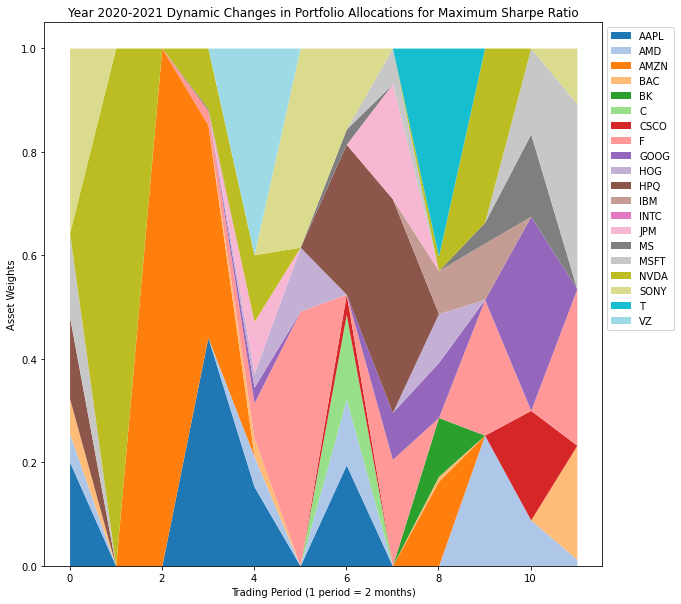

In [15]:
weight_3 = weight[3].tolist()
weight_3_df = pd.DataFrame(weight_3, columns = df.columns[1:]) # Remove the date

weight_3_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2020-2021 Dynamic Changes in Portfolio Allocations for Maximum Sharpe Ratio')

Text(0.5, 1.0, 'Year 2020-2021 Dynamic Changes in Portfolio Allocations for Equal Risk')

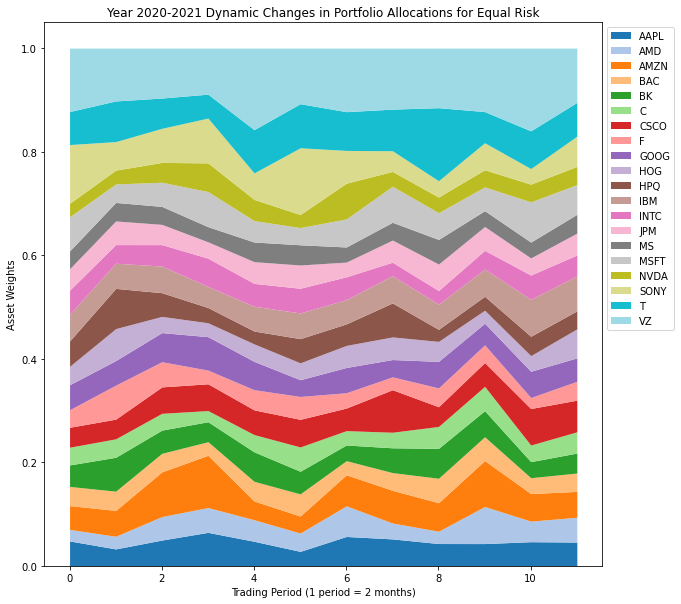

In [16]:
weight_4 = weight[4].tolist()
weight_4_df = pd.DataFrame(weight_4, columns = df.columns[1:]) # Remove the date

weight_4_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2020-2021 Dynamic Changes in Portfolio Allocations for Equal Risk')

Text(0.5, 1.0, 'Dynamic Changes in Portfolio Allocations for Leveraged Equal Risk')

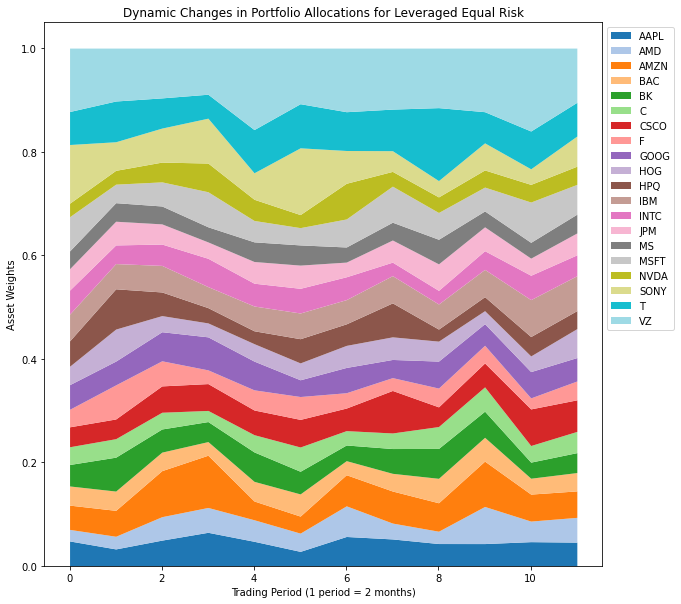

In [17]:
weight_5 = weight[5].tolist()
weight_5_df = pd.DataFrame(weight_5, columns = df.columns[1:]) # Remove the date

weight_5_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Dynamic Changes in Portfolio Allocations for Leveraged Equal Risk')

# Test Strategy for 2008-2009 Data

In [18]:
# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2007 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2007
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# # Annual risk-free rate for years 2020-2021 is 2.5%
# r_rf = 0.025
# # Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
r_rf = 0.045 # Need to set to 4.5% since we use this in our functions
# # Annual risk-free rate for year 2022 is 3.75%
# r_rf2022 = 0.0375


Initial portfolio value = $ 385097.15



In [19]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]
n=N

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

port_value_period = np.zeros((N_strat, N_periods+1),  dtype=np.ndarray)
v_borrowed = init_value

global period 

for period in range(1, N_periods+1):
    
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2008 + math.floor(period/7)
   

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # verify strategy is feasible
      if cash[strategy].any() < 0:
          print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

      # Compute portfolio value
      if strategy == 5:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]  - v_borrowed*(1.0+r_rf2008_2009/6.0)**period # assuming compound interest
      else:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/02/2008, end date 02/29/2008
  Strategy "Buy and Hold", value begin = $ 385097.15, value end = $ 325918.34
  Strategy "Equally Weighted Portfolio", value begin = $ 381647.53, value end = $ 326938.14
  Strategy "Mininum Variance Portfolio", value begin = $ 383268.36, value end = $ 327358.28
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 381265.54, value end = $ 332652.59
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 381846.82, value end = $ 329299.76
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 375707.93, value end = $ 270599.90
  Strategy "Robust Optimization Portfolio", value begin = $ 382274.61, value end = $ 332192.51

Period 2: start date 03/03/2008, end date 04/30/2008
  Strategy "Buy and Hold", value begin = $ 325807.08, value end = $ 349997.20
  Strategy "Equally Weighted Portfolio", value begin = $ 322065.15, value end = $ 354843.42
  Strategy "Mininum Variance Portfolio", value begin = $ 32

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 186009.68, value end = $ 210603.75
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 329765.68, value end = $ 368937.71
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 238216.81, value end = $ 316610.61
  Strategy "Robust Optimization Portfolio", value begin = $ 326096.71, value end = $ 364555.49


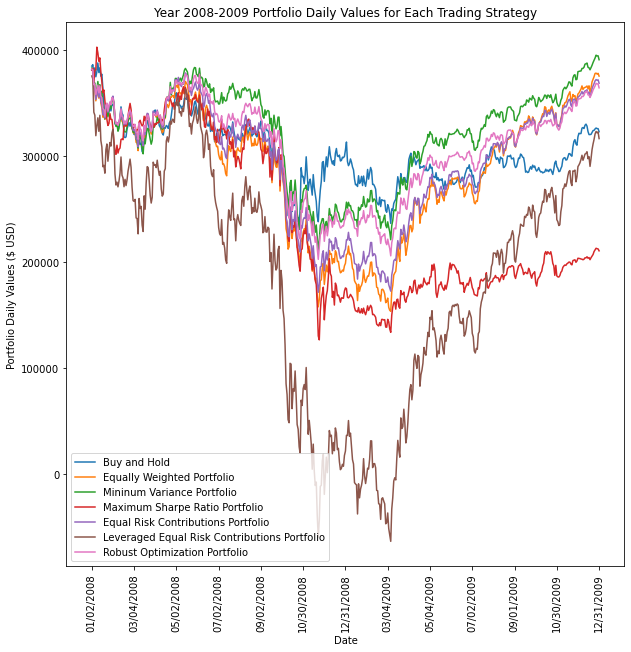

In [20]:
# Plot results
###################### Insert your code here ############################

# This chart illustrates the daily value of the portfolio for each 
# trading strategy over the years 2020 and 2021 using the daily prices. 

figure(figsize=(10, 10))

# Plotting the points
plt.plot(dates, portf_value[0], label = strategy_names[0])
plt.plot(dates, portf_value[1], label = strategy_names[1])
plt.plot(dates, portf_value[2], label = strategy_names[2])
plt.plot(dates, portf_value[3], label = strategy_names[3])
plt.plot(dates, portf_value[4], label = strategy_names[4])
plt.plot(dates, portf_value[5], label = strategy_names[5])
plt.plot(dates, portf_value[6], label = strategy_names[6])

# X axis date ticks
plt.xticks(list(dates[k] for k in list(np.linspace(0,252*2,13,dtype=int))),rotation=90)

# Labelling
plt.xlabel('Date')
plt.ylabel('Portfolio Daily Values ($ USD)')
plt.title('Year 2008-2009 Portfolio Daily Values for Each Trading Strategy')
plt.legend()
plt.show()

In [21]:
df_port_vale_period = pd.DataFrame(port_value_period.T.tolist(),columns=strategy_names)
array_portf_value = np.array(portf_value)
array_portf_value = array_portf_value.reshape(7,505)
df_port_value_daily = pd.DataFrame(array_portf_value.T.tolist(),columns=strategy_names)
df_port_value_daily

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Equal Risk Contributions Portfolio,Leveraged Equal Risk Contributions Portfolio,Robust Optimization Portfolio
0,385097.145103,381647.530126,383268.362998,381265.538647,381846.822158,375707.926253,382274.612579
1,386442.755119,380365.735265,381742.844417,382956.421826,380512.544261,373039.642217,381552.397459
2,377977.133011,364122.858678,368251.342383,369358.884854,364769.631123,341554.449173,367488.486646
3,383397.256306,361831.559571,369129.825434,381195.094219,363345.470161,338705.746391,367987.574453
4,375000.798878,352273.427211,360404.155562,381617.815014,353658.225085,319327.089205,358240.568740
...,...,...,...,...,...,...,...
500,325709.776382,378135.499485,392704.010209,211493.208874,371086.466258,320909.346644,366330.522628
501,326595.213451,378441.415510,395383.052737,213032.608727,372313.076005,323367.004336,368790.937699
502,326034.877373,377578.911141,394701.556407,212622.692513,371669.199624,322076.253067,368219.186213
503,325984.483486,378219.512293,394801.546094,212402.913022,372118.071279,322975.913938,368323.426207


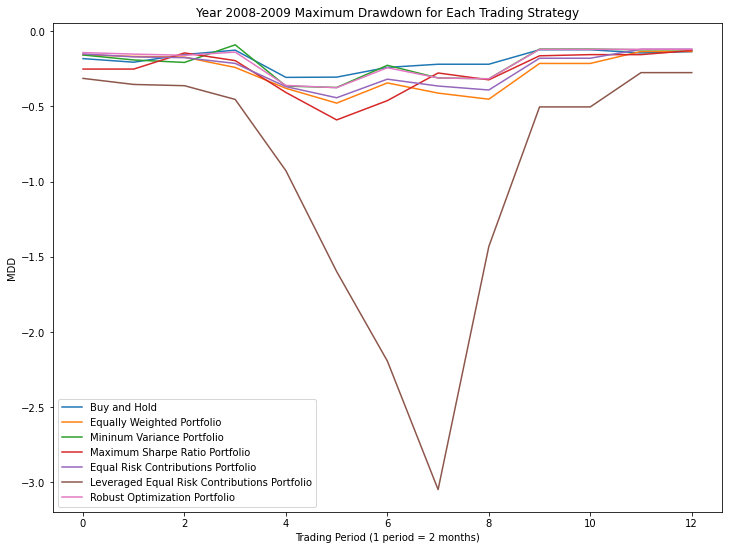

In [22]:
plt.figure(figsize=(12, 9))
plt.ylabel('MDD')
plt.xlabel('Trading Period (1 period = 2 months)')
plt.title('Year 2008-2009 Maximum Drawdown for Each Trading Strategy')
for i in range(7):
    
    Roll_Max = df_port_value_daily[strategy_names[i]].rolling(42).max()
    Roll_Min = df_port_value_daily[strategy_names[i]].rolling(42).min()
    Daily_Drawdown = (Roll_Min - Roll_Max) / Roll_Max
    Max_Drawdown = Daily_Drawdown.groupby(np.arange(len(Daily_Drawdown))//42).min()

    # Plot the results
    Max_Drawdown.plot(label=strategy_names[i])
    plt.legend()

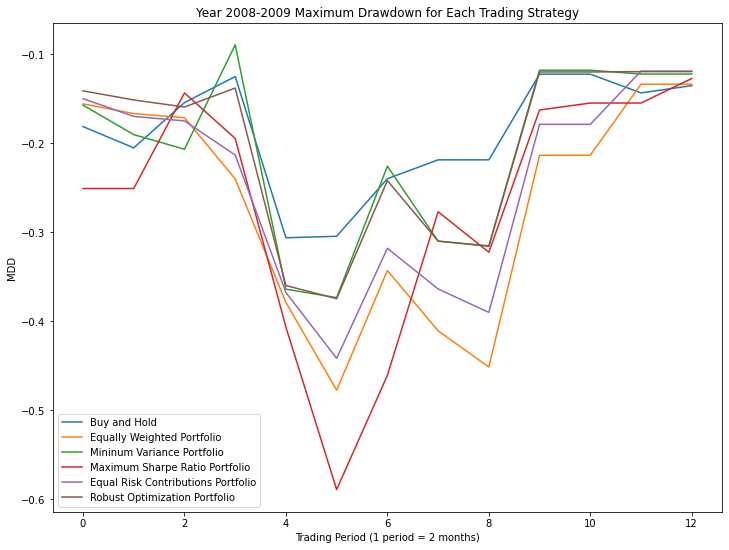

In [23]:
plt.figure(figsize=(12, 9))
plt.ylabel('MDD')
plt.xlabel('Trading Period (1 period = 2 months)')
plt.title('Year 2008-2009 Maximum Drawdown for Each Trading Strategy')
for i in range(7):
    if(i!=5):
        Roll_Max = df_port_value_daily[strategy_names[i]].rolling(42).max()
        Roll_Min = df_port_value_daily[strategy_names[i]].rolling(42).min()
        Daily_Drawdown = (Roll_Min - Roll_Max) / Roll_Max
        Max_Drawdown = Daily_Drawdown.groupby(np.arange(len(Daily_Drawdown))//42).min()

        # Plot the results
        Max_Drawdown.plot(label=strategy_names[i])
        plt.legend()

Text(0.5, 1.0, 'Year 2008-2009 Dynamic Changes in Portfolio Allocations for Minimum Variance Strategy')

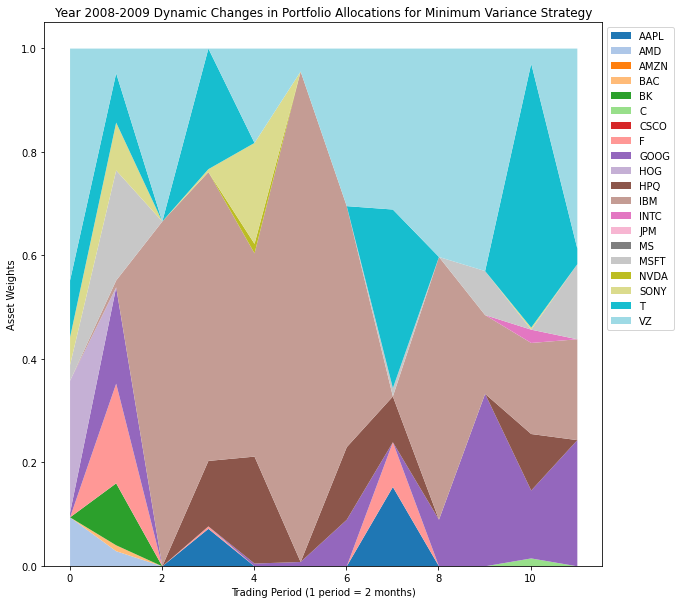

In [24]:
weight_2 = weight[2].tolist()
weight_2_df = pd.DataFrame(weight_2, columns = df.columns[1:]) # Remove the date

weight_2_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2008-2009 Dynamic Changes in Portfolio Allocations for Minimum Variance Strategy')

Text(0.5, 1.0, 'Year 2008-2009 Dynamic Changes in Portfolio Allocations for Maximum Sharpe Ratio Strategy')

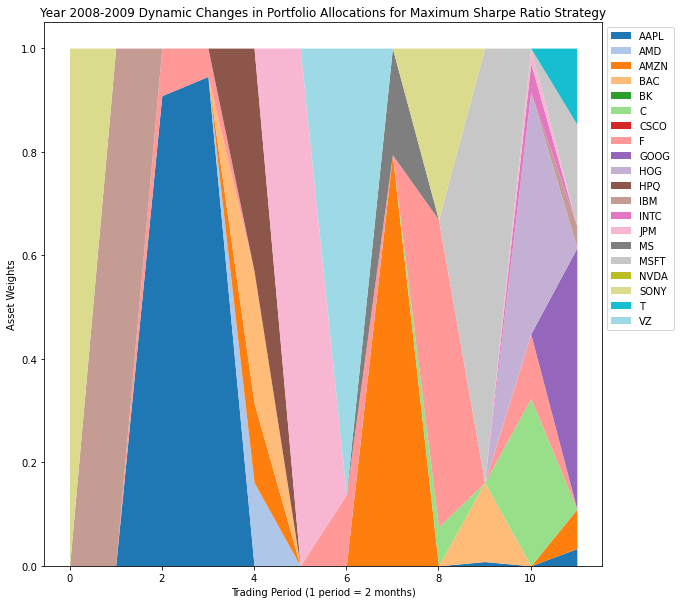

In [25]:
weight_3 = weight[3].tolist()
weight_3_df = pd.DataFrame(weight_3, columns = df.columns[1:]) # Remove the date

weight_3_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2008-2009 Dynamic Changes in Portfolio Allocations for Maximum Sharpe Ratio Strategy')

Text(0.5, 1.0, 'Year 2008-2009 Dynamic Changes in Portfolio Allocations for Robust Optimization Strategy')

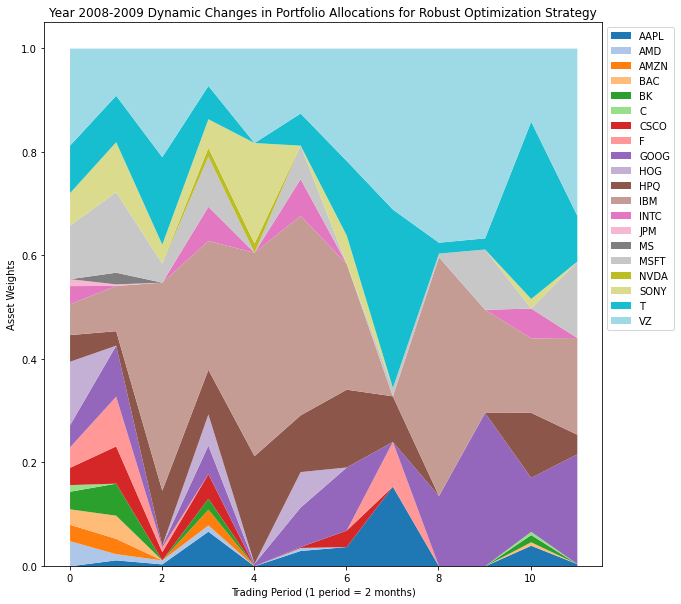

In [26]:
weight_6 = weight[6].tolist()
weight_6_df = pd.DataFrame(weight_6, columns = df.columns[1:]) # Remove the date

weight_6_df.plot.area(figsize=(10, 10), linewidth=0, colormap="tab20")

plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Trading Period (1 period = 2 months)')
plt.ylabel('Asset Weights')
plt.title('Year 2008-2009 Dynamic Changes in Portfolio Allocations for Robust Optimization Strategy')

# Test Strategy for 2022 Data

In [27]:
# Input file
input_file_prices = 'Daily_closing_prices2022.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2021 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2021)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2021
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([0, 0, 0, 0, 0, 0, 0, 0, 0, 902, 0, 0, 0, 0, 0, 0, 0, 0, 0, 17500])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# # Annual risk-free rate for years 2020-2021 is 2.5%
# r_rf = 0.025
# # Annual risk-free rate for years 2008-2009 is 4.5%
# r_rf2008_2009 = 0.045
# Annual risk-free rate for year 2022 is 3.75%
r_rf2022 = 0.0375
r_rf = 0.0375 # Need to set to 3.75% since we use this in our functions


Initial portfolio value = $ 890077.15



In [28]:
# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
# N_strat = 7  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe, strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]
n=N

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
weight = np.zeros((N_strat, N_periods),  dtype=np.ndarray) # Added

port_value_period = np.zeros((N_strat, N_periods+1),  dtype=np.ndarray)
v_borrowed = init_value

global period 

for period in range(1, N_periods+1):
    
   # Compute current year and month, first and last day of the period
   if dates_array[0, 0] == 20:
       cur_year  = 20 + math.floor(period/7)
   else:
       cur_year  = 2022 + math.floor(period/7)
   

   cur_month = 2*((period-1)%6) + 1
   day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
   day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
   print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))
   
   # Prices for the current day
   cur_prices = data_prices[day_ind_start,:]

   # Execute portfolio selection strategies
   for strategy  in range(N_strat):

      # Get current portfolio positions
      if period == 1:
         curr_positions = init_positions
         curr_cash = 0
         portf_value[strategy] = np.zeros((N_days, 1))
      else:
         curr_positions = x[strategy, period-2]
         curr_cash = cash[strategy, period-2]

      # Compute strategy
      x[strategy, period-1], cash[strategy, period-1], weight[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

      # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
      # Check that cash account is >= 0
      # Check that we can buy new portfolio subject to transaction costs

      ###################### Insert your code here ############################

      # verify strategy is feasible
      if cash[strategy].any() < 0:
          print('Strategy "{0}" is not feasible.'.format(strategy_names[strategy]))

      # Compute portfolio value
      if strategy == 5:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]  - v_borrowed*(1.0+r_rf2022/6.0)**period # assuming compound interest
      else:
          p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
      portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
      print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy], 
             portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))

      
   # Compute expected returns and covariances for the next period
   cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
   mu = np.mean(cur_returns, axis = 0)
   Q = np.cov(cur_returns.T)


Period 1: start date 01/03/2022, end date 02/28/2022
  Strategy "Buy and Hold", value begin = $ 890077.15, value end = $ 924072.93
  Strategy "Equally Weighted Portfolio", value begin = $ 881998.87, value end = $ 802771.38
  Strategy "Mininum Variance Portfolio", value begin = $ 885903.36, value end = $ 863773.70
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 881221.32, value end = $ 800281.21
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 882741.73, value end = $ 817665.70
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 869847.27, value end = $ 739757.29
  Strategy "Robust Optimization Portfolio", value begin = $ 883508.50, value end = $ 825486.75

Period 2: start date 03/01/2022, end date 04/29/2022
  Strategy "Buy and Hold", value begin = $ 921940.14, value end = $ 807230.89
  Strategy "Equally Weighted Portfolio", value begin = $ 783266.45, value end = $ 705860.50
  Strategy "Mininum Variance Portfolio", value begin = $ 85

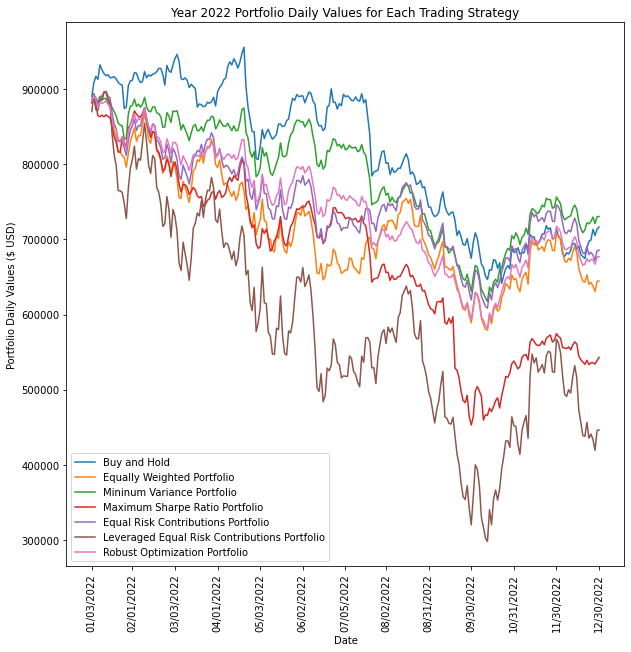

In [29]:
# Plot results
###################### Insert your code here ############################

# This chart illustrates the daily value of the portfolio for each 
# trading strategy over the years 2022 using the daily prices. 

figure(figsize=(10, 10))

# Plotting the points
plt.plot(dates, portf_value[0], label = strategy_names[0])
plt.plot(dates, portf_value[1], label = strategy_names[1])
plt.plot(dates, portf_value[2], label = strategy_names[2])
plt.plot(dates, portf_value[3], label = strategy_names[3])
plt.plot(dates, portf_value[4], label = strategy_names[4])
plt.plot(dates, portf_value[5], label = strategy_names[5])
plt.plot(dates, portf_value[6], label = strategy_names[6])

# X axis date ticks
plt.xticks(list(dates[k] for k in list(np.linspace(0,250,13,dtype=int))),rotation=90)

# Labelling
plt.xlabel('Date')
plt.ylabel('Portfolio Daily Values ($ USD)')
plt.title('Year 2022 Portfolio Daily Values for Each Trading Strategy')
plt.legend()
plt.show()

In [30]:
df_port_vale_period = pd.DataFrame(port_value_period.T.tolist(),columns=strategy_names)
array_portf_value = np.array(portf_value)
array_portf_value = array_portf_value.reshape(7,251)
df_port_value_daily = pd.DataFrame(array_portf_value.T.tolist(),columns=strategy_names)
df_port_value_daily

,Buy and Hold,Equally Weighted Portfolio,Mininum Variance Portfolio,Maximum Sharpe Ratio Portfolio,Equal Risk Contributions Portfolio,Leveraged Equal Risk Contributions Portfolio,Robust Optimization Portfolio
0,890077.147408,881998.871114,885903.360902,881221.317096,882741.730499,869847.266955,883508.504033
1,908083.044834,893642.376598,891686.799001,886217.000681,893810.908221,891983.059803,891010.819178
2,916543.477766,878632.109570,888044.707977,878302.587196,883828.755177,872041.028349,884838.571213
3,912669.137478,881830.055655,879692.651454,864351.662463,883464.760809,871314.042978,875830.992997
4,931939.450494,885461.548951,889482.906935,862968.068555,889957.998075,884296.144728,881908.766447
...,...,...,...,...,...,...,...
246,699132.193196,642685.998065,723838.473220,535800.834063,682666.306650,441114.447596,672800.671963
247,713234.873196,637435.518461,729488.369709,536048.221317,678983.550598,433741.614461,673639.668526
248,705004.610902,630659.188841,720858.903701,534143.254112,671806.961746,419379.637690,666851.128307
249,713398.090000,644096.087749,729948.392495,538880.984951,684999.214880,445773.887348,676784.527861


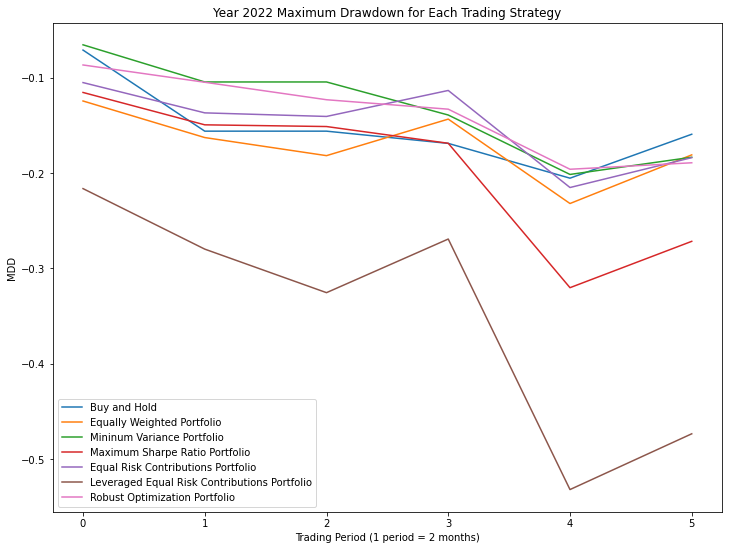

In [31]:
plt.figure(figsize=(12, 9))
plt.ylabel('MDD')
plt.xlabel('Trading Period (1 period = 2 months)')
plt.title('Year 2022 Maximum Drawdown for Each Trading Strategy')
for i in range(7):
    
    Roll_Max = df_port_value_daily[strategy_names[i]].rolling(42).max()
    Roll_Min = df_port_value_daily[strategy_names[i]].rolling(42).min()
    Daily_Drawdown = (Roll_Min - Roll_Max) / Roll_Max
    Max_Drawdown = Daily_Drawdown.groupby(np.arange(len(Daily_Drawdown))//42).min()

    # Plot the results
    Max_Drawdown.plot(label=strategy_names[i])
    plt.legend()